In [806]:
import pandas as pd
import copy
import numpy as np
import seaborn as sns
from sklearn.metrics import r2_score
import scipy

## Append HLL 

In [426]:
# !pip install hyperloglog

In [778]:
import hyperloglog
import random
from scipy import spatial
import string

def create_hll_from_list(l):
    hll = hyperloglog.HyperLogLog(error_rate=0.04)
    for item in l:
        hll.add(item)
    return hll
def get_merged_hll(hll1, hll2):
    m_hll = copy.deepcopy(hll1)
    m_hll.update(hll2)
    return m_hll

def estimate_overlapping_coef(hll1: hyperloglog.HyperLogLog, hll2):
    card_1 = hll1.card()
    card_2 = hll2.card()
    m_hll = get_merged_hll(hll1, hll2)
    union_card = m_hll.card()
    return  (card_1+card_2-union_card)/(min(card_1,card_2))

def cosine_distance_hll(hll1: hyperloglog.HyperLogLog, hll2):
    v1 = hll1.M
    v2 = hll2.M
    return spatial.distance.cosine(v1, v2)
def euclidean_hll(hll1: hyperloglog.HyperLogLog, hll2):
    v1 = hll1.M
    v2 = hll2.M
    return spatial.distance.euclidean(v1, v2)
def inner_product_hll(hll1: hyperloglog.HyperLogLog, hll2):
    v1 = hll1.M
    v2 = hll2.M
    return np.inner(v1,v2)

def get_intersection_size(a:list,b:list):
    a_set = set(a)
    b_set = set(b)
    inter = a_set.intersection(b_set)
    return len(inter)

def estimate_intersection(hll1, hll2):
    card_1 = hll1.card()
    card_2 = hll2.card()
    m_hll = get_merged_hll(hll1, hll2)
    union_card = m_hll.card()
    return card_1+card_2-union_card

def get_hll_overlap_estimation(a,b):
    hll_a = create_hll_from_list(a)
    hll_b = create_hll_from_list(b)
    return estimate_overlapping_coef(hll_a, hll_b)

In [779]:
import math 

def random_str(l):
    return ''.join(random.choice( string.digits) for _ in range(l))
def create_random_items(size:int):
    distinct_items = set()
    s_len = 1
    i = 1
    while len(distinct_items)<size:
        key = random_str(int(s_len))
        distinct_items.add(key)
        i=i+1
        s_len = max(math.log2(i/9),1)
        
    return list(distinct_items)
def create_random_list(size:int, items):
    a = []
    for i in range(size):
        item = random.choice(items)
        a.append(item)
    return set(a)
def create_synthetic_pairs_sets(total:int):
    a = []
    b = []
    for i in range(total):
        a_size = random.randint(200,1000)
        b_size = random.randint(150,300)
        items = create_random_items(max(a_size*1.1,b_size*1.1))
        b.append(create_random_list(b_size,items))
        a.append(create_random_list(a_size,items))
    return pd.DataFrame({'a':a,'b':b})


In [780]:
import math

def get_overlap_coef(a,b):
    a_set = set(a)
    b_set = set(b)
    inter_set = a_set.intersection(b_set)
    return len(inter_set)/min(len(a_set),len(b_set))

def get_cosine_set(a,b):
    a_set = set(a)
    b_set = set(b)
    inter_set = a_set.intersection(b_set)
    return len(inter_set)/(math.sqrt(len(a_set))*math.sqrt(len(b_set)))

def get_enclidian_set(a,b):
    a_set = set(a)
    b_set = set(b)
    inter_set = a_set.intersection(b_set)
    return math.sqrt( len(a_set)-len(inter_set) + len(b_set)-len(inter_set))

In [781]:
df = create_synthetic_pairs_sets(300)

In [782]:
df

,a,b
0,"{5603, 409, 4256, 714, 0777, 2635, 966, 84919,...","{5603, 81672, 2635, 5573, 8141, 14718, 93, 579..."
1,"{753, 7026, 109, 1081, 38147, 7278, 714, 83156...","{753, 1081, 8521, 466, 50801, 714, 45, 1866, 6..."
2,"{10187, 248484, 57892, 34293, 759430, 316357, ...","{7026, 87660, 328076, 988085, 770354, 91740, 7..."
3,"{050, 3571, 359, 7072, 45928, 2207, 52182, 265...","{50910, 359, 7072, 64, 52182, 40732, 26594, 03..."
4,"{82433, 66882, 763, 83550, 825474, 51817, 6086...","{82433, 59269, 73439, 66882, 773053, 70184, 06..."
...,...,...
295,"{41457, 876, 521, 8835, 690, 714, 2675, 849, 8...","{41457, 99292, 756, 91857, 2675, 892, 849, 237..."
296,"{71126, 63493, 35804, 550184, 92014, 29154, 21...","{876, 37769, 037789, 366725, 742586, 399414, 9..."
297,"{813068, 06795, 70099, 37622, 27844, 30176, 29...","{359, 70099, 06643, 623970, 1010, 426, 756310,..."
298,"{111, 521, 864, 4884, 252, 896, 412, 1202, 759...","{111, 521, 4884, 7244, 896, 0124, 6115, 30585,..."


In [783]:
df["overlap_coeficient"] = df.apply(lambda r: get_overlap_coef(r['a'],r['b']), axis=1)

In [784]:
df["cosine_set"] = df.apply(lambda r: get_cosine_set(r['a'],r['b']), axis=1)

In [785]:
df["euclidian_set"] = df.apply(lambda r: get_enclidian_set(r['a'],r['b']), axis=1)

In [786]:
df["hll_overlap"] = df.apply(lambda r: get_hll_overlap_estimation(r['a'],r['b']), axis=1)

In [787]:
df["a_size"] = df["a"].apply(lambda x: len(x))
df["b_size"] = df["b"].apply(lambda x: len(x))

<Axes: >

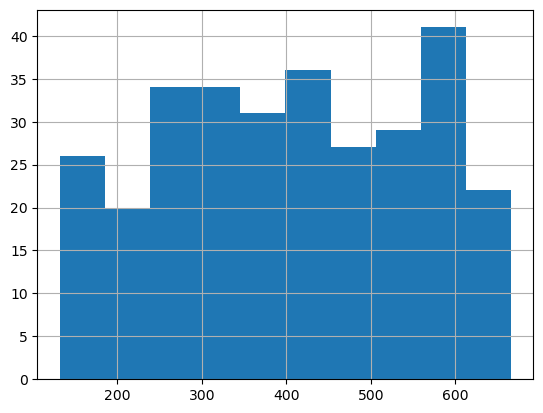

In [788]:
df["a_size"].hist()

In [789]:
df["a_hll"] = df["a"].apply(lambda x: create_hll_from_list(x))
df["b_hll"] = df["b"].apply(lambda x: create_hll_from_list(x))

In [790]:
df["m_hll"] = df.apply(lambda x: get_merged_hll(x['a_hll'], x['b_hll']), axis=1)

In [791]:
df["inter_size"] = df.apply(lambda r: get_intersection_size(r['a'],r['b']), axis=1)
df["inter_hll_estimation"] = df.apply(lambda r: estimate_intersection(r['a_hll'],r['b_hll']), axis=1)

In [792]:
df["a_hll_size"] =  df["a_hll"].apply(lambda x: x.m)
df["b_hll_size"] =  df["b_hll"].apply(lambda x: x.m)


In [793]:
df["a_hll_card"] =  df["a_hll"].apply(lambda x: x.card())
df["b_hll_card"] =  df["b_hll"].apply(lambda x: x.card())
df["m_hll_card"] = df["m_hll"].apply(lambda x: x.card())

In [794]:
df["a_hll_size"] 

0      1024
1      1024
2      1024
3      1024
4      1024
       ... 
295    1024
296    1024
297    1024
298    1024
299    1024
Name: a_hll_size, Length: 300, dtype: int64

<Axes: >

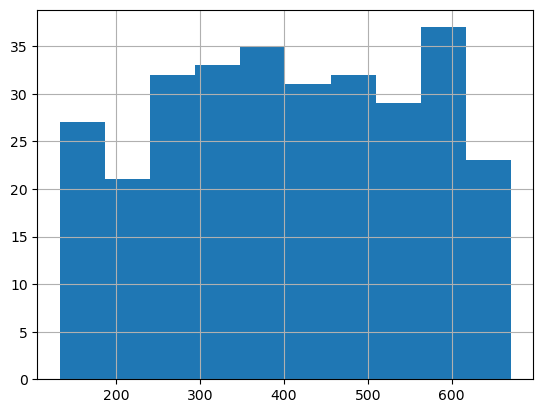

In [795]:
df["a_hll_card"].hist()

<Axes: >

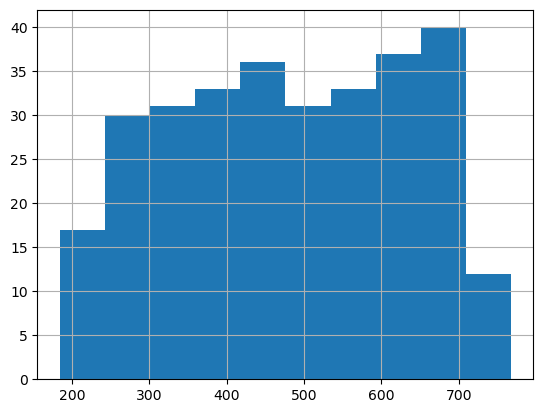

In [796]:
df["m_hll_card"].hist()

PearsonRResult(statistic=0.9971941192933998, pvalue=0.0)

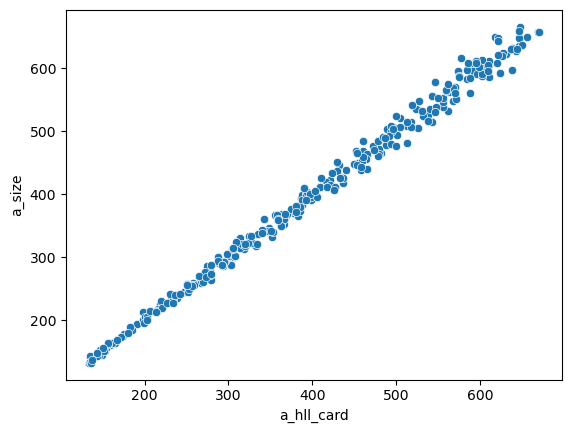

In [812]:

sns.scatterplot(df, x='a_hll_card', y='a_size')
scipy.stats.pearsonr(df["a_hll_card"], df["a_size"])

In [813]:
df[["a_size", "b_size", "inter_size", "inter_hll_estimation"]].sample(10).head(20)

,a_size,b_size,inter_size,inter_hll_estimation
11,164,183,93,95.004173
154,258,203,115,113.145881
226,189,186,108,101.732788
248,561,253,141,146.156014
188,459,244,145,131.875314
89,536,244,149,141.561037
121,632,186,110,103.956137
29,648,174,104,108.381661
34,526,173,92,95.697261
249,214,127,78,81.336425


PearsonRResult(statistic=0.9641153475723574, pvalue=1.1053839548388404e-173)

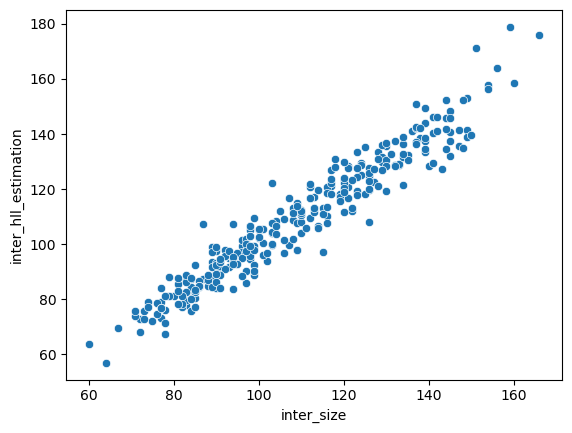

In [810]:

sns.scatterplot(df, x='inter_size', y='inter_hll_estimation')
scipy.stats.pearsonr(df["inter_size"], df["inter_hll_estimation"])

PearsonRResult(statistic=0.7360190535672508, pvalue=2.0150954131732495e-52)

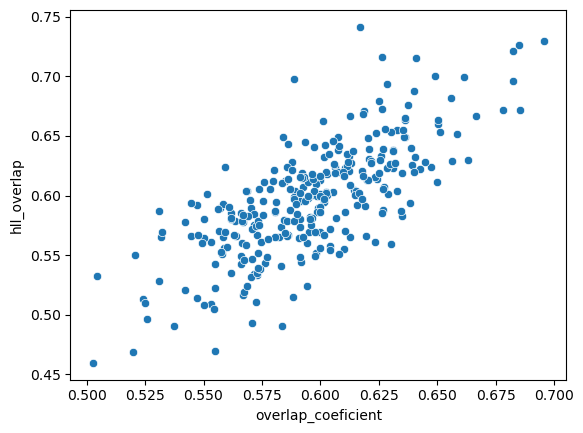

In [814]:

sns.scatterplot(df, x='overlap_coeficient', y='hll_overlap')
scipy.stats.pearsonr(df["overlap_coeficient"], df["hll_overlap"])


In [801]:
df.head()

,a,b,overlap_coeficient,cosine_set,euclidian_set,hll_overlap,a_size,b_size,a_hll,b_hll,m_hll,inter_size,inter_hll_estimation,a_hll_size,b_hll_size,a_hll_card,b_hll_card,m_hll_card
0,"{5603, 409, 4256, 714, 0777, 2635, 966, 84919,...","{5603, 81672, 2635, 5573, 8141, 14718, 93, 579...",0.595238,0.480947,13.000000,0.569743,193,126,<hyperloglog.hll.HyperLogLog object at 0x3128f...,<hyperloglog.hll.HyperLogLog object at 0x315b0...,<hyperloglog.hll.HyperLogLog object at 0x315b7...,75,72.073477,1024,1024,190.705107,126.501747,245.133377
1,"{753, 7026, 109, 1081, 38147, 7278, 714, 83156...","{753, 1081, 8521, 466, 50801, 714, 45, 1866, 6...",0.588957,0.552830,12.489996,0.604134,163,185,<hyperloglog.hll.HyperLogLog object at 0x315c2...,<hyperloglog.hll.HyperLogLog object at 0x315ad...,<hyperloglog.hll.HyperLogLog object at 0x3179e...,96,99.403429,1024,1024,164.538759,178.728362,243.863693
2,"{10187, 248484, 57892, 34293, 759430, 316357, ...","{7026, 87660, 328076, 988085, 770354, 91740, 7...",0.610294,0.308569,22.405357,0.554799,532,136,<hyperloglog.hll.HyperLogLog object at 0x31798...,<hyperloglog.hll.HyperLogLog object at 0x30fcd...,<hyperloglog.hll.HyperLogLog object at 0x3179c...,83,77.766482,1024,1024,561.116335,140.170470,623.520323
3,"{050, 3571, 359, 7072, 45928, 2207, 52182, 265...","{50910, 359, 7072, 64, 52182, 40732, 26594, 03...",0.600000,0.544892,12.727922,0.613094,160,194,<hyperloglog.hll.HyperLogLog object at 0x315cb...,<hyperloglog.hll.HyperLogLog object at 0x3179e...,<hyperloglog.hll.HyperLogLog object at 0x315cd...,96,97.288213,1024,1024,158.683969,200.388394,261.784150
4,"{82433, 66882, 763, 83550, 825474, 51817, 6086...","{82433, 59269, 73439, 66882, 773053, 70184, 06...",0.566802,0.412655,20.808652,0.516333,466,247,<hyperloglog.hll.HyperLogLog object at 0x315cd...,<hyperloglog.hll.HyperLogLog object at 0x315d0...,<hyperloglog.hll.HyperLogLog object at 0x30fcb...,140,128.542054,1024,1024,481.283716,248.951902,601.693564


In [817]:
df['cosine_hll'] = df.apply(lambda x: cosine_distance_hll(x['a_hll'],x['b_hll']), axis=1)
df['euclidean_hll'] = df.apply(lambda x: euclidean_hll(x['a_hll'],x['b_hll']), axis=1)
df['inner_product_hll'] = df.apply(lambda x: inner_product_hll(x['a_hll'],x['b_hll']), axis=1)

PearsonRResult(statistic=0.7360190535672508, pvalue=2.0150954131732495e-52)


<Axes: xlabel='overlap_coeficient', ylabel='hll_overlap'>

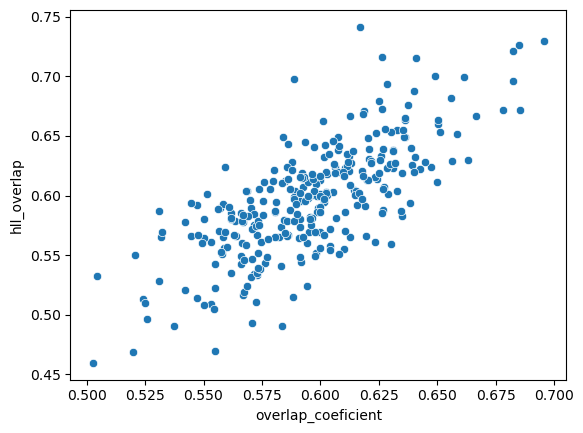

In [818]:
from sklearn.metrics import r2_score

correlation = scipy.stats.pearsonr(df["hll_overlap"], df["overlap_coeficient"])
print(correlation)
sns.scatterplot(df, x='overlap_coeficient',y='hll_overlap' )

PearsonRResult(statistic=-0.25205091218764525, pvalue=9.916997098154512e-06)


<Axes: xlabel='overlap_coeficient', ylabel='cosine_hll'>

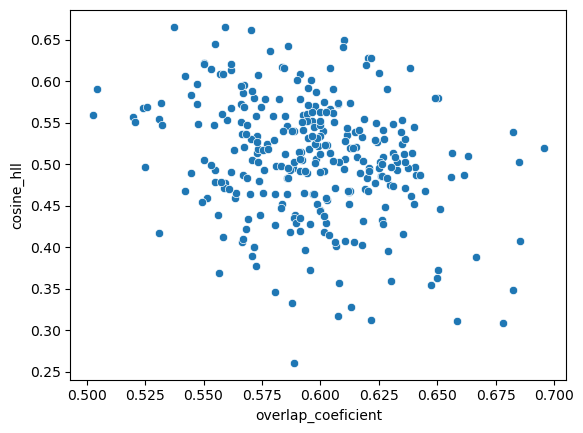

In [819]:
correlation = scipy.stats.pearsonr(df["cosine_hll"], df["overlap_coeficient"])
print(correlation)
sns.scatterplot(df, x='overlap_coeficient',y='cosine_hll' )

-25.636106853988014


<Axes: xlabel='overlap_coeficient', ylabel='euclidean_hll'>

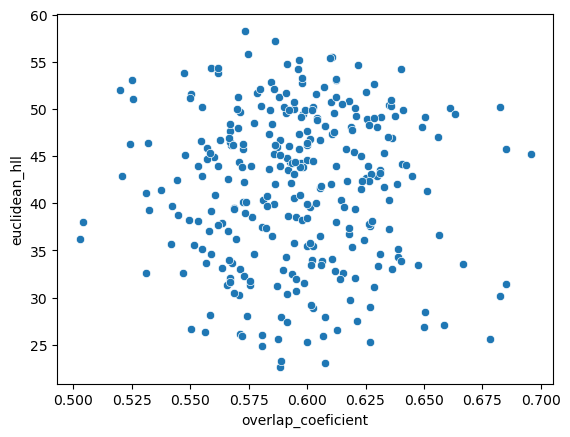

In [820]:


coefficient_of_dermination = r2_score(df["euclidean_hll"], df["overlap_coeficient"])
print(coefficient_of_dermination)
sns.scatterplot(df, x='overlap_coeficient',y='euclidean_hll' )

-15.52353909923433


<Axes: xlabel='overlap_coeficient', ylabel='inner_product_hll'>

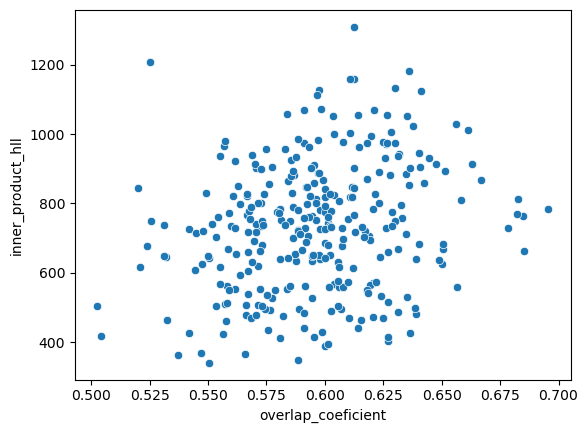

In [821]:


coefficient_of_dermination = r2_score(df["inner_product_hll"], df["overlap_coeficient"])
print(coefficient_of_dermination)
sns.scatterplot(df, x='overlap_coeficient',y='inner_product_hll' )

-14.063055073909277


<Axes: xlabel='inner_product_hll', ylabel='cosine_hll'>

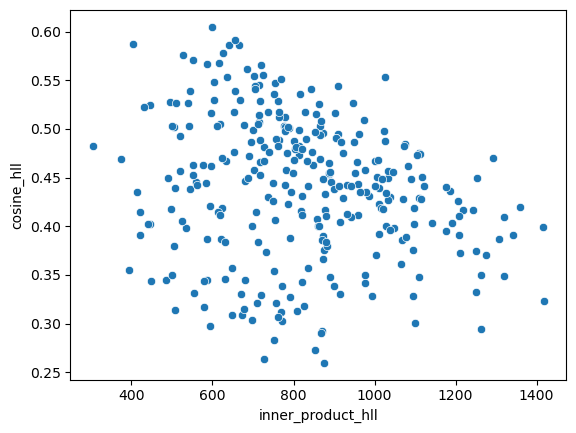

In [767]:

coefficient_of_dermination = r2_score(df["inner_product_hll"], df["cosine_hll"])
print(coefficient_of_dermination)
sns.scatterplot(df, x='inner_product_hll',y='cosine_hll' )

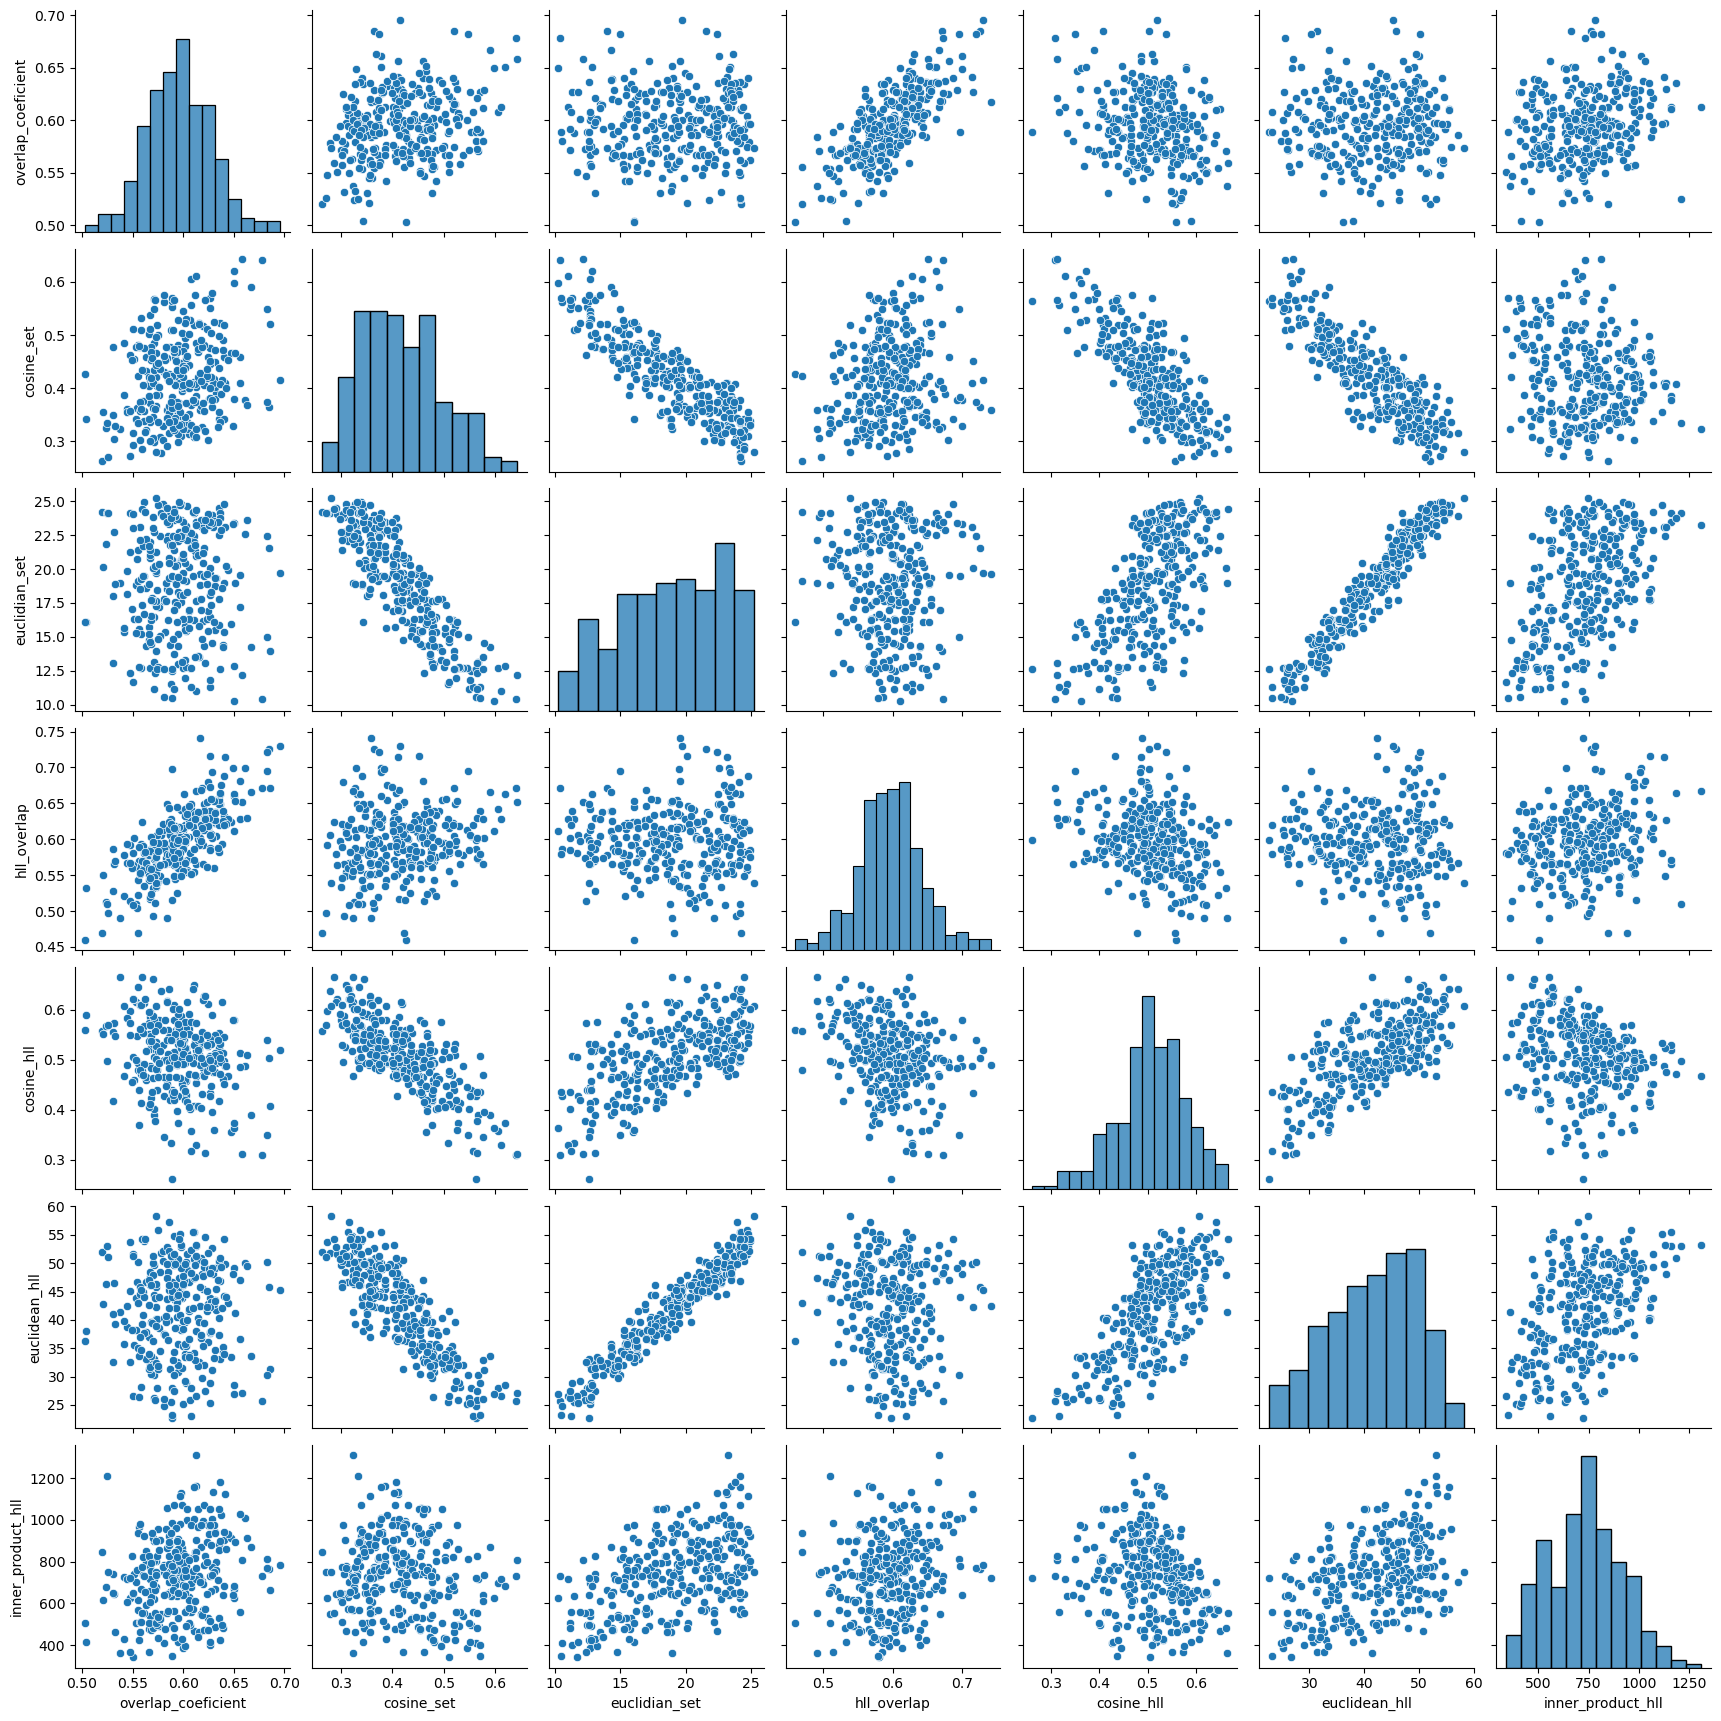

In [822]:
data = df[['overlap_coeficient','cosine_set','euclidian_set','hll_overlap','cosine_hll',"euclidean_hll","inner_product_hll"]]
sns.pairplot(data)

In [774]:
from pympler import asizeof
df['a_bytes'] = df['a'].apply(lambda x: asizeof.asizeof(x))
df['a_hll_bytes'] = df['a_hll'].apply(lambda x: asizeof.asizeof(x))

In [775]:
df[['a_bytes','a_hll_bytes']].mean()

a_bytes        48309.92
a_hll_bytes     4669.44
dtype: float64

In [776]:
df['a_hll_bytes'].mean()/df['a_bytes'].mean()

0.09665592491148815

array([[<Axes: title={'center': 'a_bytes'}>,
        <Axes: title={'center': 'a_hll_bytes'}>]], dtype=object)

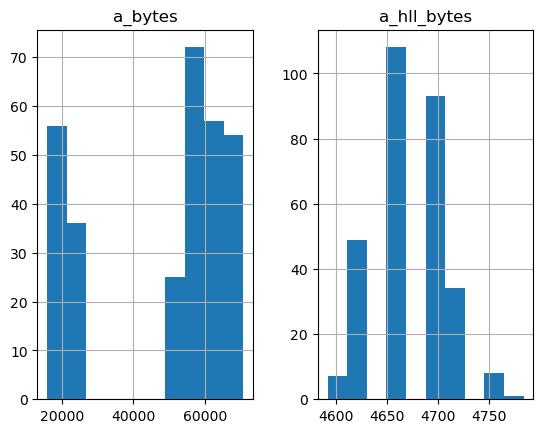

In [777]:
df[['a_bytes','a_hll_bytes']].hist()

In [188]:
!pip install HLL

In [5]:
import random
from HLL import HyperLogLog

hll = HyperLogLog(14, seed=3224) # use 2^10 registers
hll.add('some data')
hll.add('b data')
estimate = hll.cardinality()
print(estimate)

hll2 = HyperLogLog(14, seed=3224) # use 2^10 registers
hll2.add('some data')
hll2.add('a data')

m_hll = copy.deepcopy(hll)
m_hll.merge(hll2)

print(hll.cardinality())
print(m_hll.cardinality())

2


NameError: name 'copy' is not defined

In [11]:
import time
import copy

def measure_execution_time(func, *args, **kwargs):
    start_time = time.time()
    func(*args, **kwargs)
    end_time = time.time()
    duration = end_time - start_time
    print(f"{func.__name__} took {duration} seconds to execute")


In [562]:
def exp_hll_new():
    hll = HyperLogLog(10) # use 2^10 registers
    for i in range(3000):
        hll.add('some data'+str(random.randint(0,20000)))
    print(hll.cardinality())
    v = hll.get_register(0)
    s = hll.size()
    print(s)
    print(v)
    print(asizeof.asizeof(v))
    print(asizeof.asizeof(v)*s)
     
    print('--------')
    hll2 = HyperLogLog(10) # use 2^10 registers
    for i in range(3000):
        hll2.add('some data'+str(random.randint(0,20000)))
    print(hll2.cardinality())
    v2 = hll2.get_register(0)
    s2 = hll2.size()
    print(s2)
    # print(v2)
    # print(asizeof.asizeof(v2))
    print(asizeof.asizeof(v2)*s2)
    
    print('--------')
    
    print('union')
    
    inter_len = -1
    
    
    for i in range(10000):
        m_hll = copy.deepcopy(hll)
        m_hll.merge(hll2)
        inter_len = hll.cardinality()+hll2.cardinality() - m_hll.cardinality()
    print(m_hll.cardinality())
    print(inter_len)
    

measure_execution_time(exp_hll_new)

2711
1024
0
32
32768
--------
2819
1024
32768
--------
union
5188
342
exp_hll_new took 2.6899068355560303 seconds to execute


In [559]:
def exp_set():
    a = set()
    for i in range(3000):
        a.add('some data'+str(random.randint(0,20000)))
    a_len = len(a)
    print(a_len)
     
    print('--------')
    b = set()
    for i in range(3000):
        b.add('some data'+str(random.randint(0,20000)))
    b_len = len(b)
    print(b_len)
   
    
    print('--------')
    inter = None
    in_len = -1
    for i in range(10000):
        inter = a.intersection(b)
        in_len = len(inter)
    print('in_len')
    print(in_len)
    
measure_execution_time(exp_set)

2809
--------
2803
--------
in_len
403
exp_set took 0.49001288414001465 seconds to execute


In [561]:
import hyperloglog
import random
def exp_hll_old():
    hll = hyperloglog.HyperLogLog(error_rate=0.05)
    print(hll.m)
    for i in range(3000):
        hll.add('some data'+str(random.randint(0,20000)))
    print(hll.card())
    print(asizeof.asizeof(hll))
    
    
    hll2 = hyperloglog.HyperLogLog(error_rate=0.05)
    print(hll2.m)
    for i in range(3000):
        hll2.add('some data'+str(random.randint(0,20000)))
    print(hll2.card())
    print(asizeof.asizeof(hll2))
    
    
    inter_card = -1
    
    
    for i in range(10000):
        m_hll = copy.copy(hll)
        m_hll.update(hll2)
        inter_card = hll.card() + hll2.card() - m_hll.card()
    print(f'hll {hll.card()}')
    
    print(f'union {m_hll.card()}')
    
    print(f'inter {inter_card }')
    print(f'm {m_hll.m}')
    
measure_execution_time(exp_hll_old)

512
2849.1687190722996
4784
512
2859.089580788771
4752
hll 2849.1687190722996
union 5301.431458172381
inter 406.82684168868946
m 512
exp_hll_old took 1.203333854675293 seconds to execute


In [422]:
1 << 4

16

In [828]:
int(math.ceil(math.log((1.04 / 0.005) ** 2, 2)))

16